In [2]:
# Install required libraries
!pip install -r requirements.txt

Looking in indexes: https://ship-nexus.maestro.gov.sg/repository/pypi-proxy/simple/


In [3]:
# Import required libraries
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random

# Set random seed
np.random.seed(500)
random.seed(500)

In [4]:
# Define a class to represent our hospital ED
class EDSimulation:
    def __init__(self, env):
        self.env = env
        
        # Resources (nurses, doctors, and beds)
        self.fast_track_nurse = simpy.Resource(env, capacity=1)
        self.fast_track_doctor = simpy.Resource(env, capacity=1)
        self.main_ed_nurses = simpy.Resource(env, capacity=3)  # Starting with 3 nurses
        self.main_ed_doctors = simpy.Resource(env, capacity=2)  # Starting with 2 doctors
        self.main_ed_beds = simpy.Resource(env, capacity=10)   # Starting with 10 beds
        
        # Data collection
        self.patient_data = []
        self.queue_data = []
        self.resource_utilisation = defaultdict(list)
        
        # Patient counters
        self.patient_id = 0
        
    # Define a function to generate patient arrival time
    def patient_arrival(self):
        while True:
            # Patient inter-arrival time, exponentially-distributed with average 15 minutes
            inter_arrival_time = np.random.exponential(15)
            yield self.env.timeout(inter_arrival_time)
            
            self.patient_id += 1
            patient_type = self.determine_patient_type()
            
            # Start patient journey
            self.env.process(self.patient_journey(self.patient_id, patient_type))
    
    # Define a function to randomise patients into Fast Track or Main ED
    def determine_patient_type(self):
        # Assume 40% of patients are suitable for Fast Track, 60% for Main ED track
        if random.random() < 0.4:
            return "fast_track"
        else:
            return "main_ed"
    
    # Define a function to simulate the entire patient ED pathway
    def patient_journey(self, patient_id, patient_type):
        arrival_time = self.env.now
        
        if patient_type == "fast_track":
            yield self.env.process(self.fast_track_process(patient_id, arrival_time))
        else:
            yield self.env.process(self.main_ed_process(patient_id, arrival_time))
    
    # Define a function for the Fast Track process
    def fast_track_process(self, patient_id, arrival_time):
        # Wait for nurse
        nurse_queue_start = self.env.now
        with self.fast_track_nurse.request() as nurse_req:
            yield nurse_req
            nurse_wait_time = self.env.now - nurse_queue_start
            
            # Nurse assessment (5-15 minutes)
            nurse_time = np.random.uniform(5, 15)
            yield self.env.timeout(nurse_time)
        
        # Wait for doctor
        doctor_queue_start = self.env.now
        with self.fast_track_doctor.request() as doctor_req:
            yield doctor_req
            doctor_wait_time = self.env.now - doctor_queue_start
            
            # Doctor consultation (10-30 minutes)
            doctor_time = np.random.uniform(10, 30)
            yield self.env.timeout(doctor_time)
        
        # Patient discharged
        total_time = self.env.now - arrival_time
        
        # Record data
        self.patient_data.append({
            'patient_id': patient_id,
            'type': 'fast_track',
            'arrival_time': arrival_time,
            'departure_time': self.env.now,
            'total_time': total_time,
            'nurse_wait_time': nurse_wait_time,
            'doctor_wait_time': doctor_wait_time,
            'outcome': 'discharged'
        })
    
    # Define a function for the Main ED process
    def main_ed_process(self, patient_id, arrival_time):
        # Get bed first
        bed_queue_start = self.env.now
        with self.main_ed_beds.request() as bed_req:
            yield bed_req
            bed_wait_time = self.env.now - bed_queue_start
            
            # Initial nurse assessment
            nurse_queue_start = self.env.now
            with self.main_ed_nurses.request() as nurse_req:
                yield nurse_req
                nurse_wait_time = self.env.now - nurse_queue_start
                
                # Nurse assessment (10-20 minutes)
                nurse_time = np.random.uniform(10, 20)
                yield self.env.timeout(nurse_time)
            
            # Doctor consultation
            doctor_queue_start = self.env.now
            with self.main_ed_doctors.request() as doctor_req:
                yield doctor_req
                doctor_wait_time = self.env.now - doctor_queue_start
                
                # Doctor consultation (20-60 minutes)
                doctor_time = np.random.uniform(20, 60)
                yield self.env.timeout(doctor_time)
            
            # Determine if lab tests needed (60% chance)
            needs_lab = random.random() < 0.6
            lab_wait_time = 0
            
            if needs_lab:
                # Lab processing time (30-90 minutes)
                lab_time = np.random.uniform(30, 90)
                yield self.env.timeout(lab_time)
            
            # Determine outcome (70% discharged, 30% admitted)
            if random.random() < 0.7:
                outcome = 'discharged'
                # Additional discharge processing (15-30 minutes)
                discharge_time = np.random.uniform(15, 30)
                yield self.env.timeout(discharge_time)
            else:
                outcome = 'admitted'
                # Wait for admission (can be long - 60-300 minutes)
                admission_wait = np.random.uniform(60, 300)
                yield self.env.timeout(admission_wait)
        
        # Record data
        total_time = self.env.now - arrival_time
        self.patient_data.append({
            'patient_id': patient_id,
            'type': 'main_ed',
            'arrival_time': arrival_time,
            'departure_time': self.env.now,
            'total_time': total_time,
            'bed_wait_time': bed_wait_time,
            'nurse_wait_time': nurse_wait_time,
            'doctor_wait_time': doctor_wait_time,
            'needs_lab': needs_lab,
            'outcome': outcome
        })
    
    # Define a function to monitor queue lengths and resource utilisation
    def monitor_queues(self):
        while True:
            # Record current state
            self.queue_data.append({
                'time': self.env.now,
                'fast_track_nurse_queue': len(self.fast_track_nurse.queue),
                'fast_track_doctor_queue': len(self.fast_track_doctor.queue),
                'main_ed_nurse_queue': len(self.main_ed_nurses.queue),
                'main_ed_doctor_queue': len(self.main_ed_doctors.queue),
                'main_ed_bed_queue': len(self.main_ed_beds.queue),
                'fast_track_nurse_busy': self.fast_track_nurse.count,
                'fast_track_doctor_busy': self.fast_track_doctor.count,
                'main_ed_nurses_busy': self.main_ed_nurses.count,
                'main_ed_doctors_busy': self.main_ed_doctors.count,
                'main_ed_beds_busy': self.main_ed_beds.count
            })
            
            # Check every 30 minutes
            yield self.env.timeout(30)

In [5]:
# Define a function to run the simulation model for 24 hours
def run_simulation(simulation_time=24*60, scenario_name="Baseline"):
    env = simpy.Environment()
    ed_sim = EDSimulation(env)
    
    # Start processes
    env.process(ed_sim.patient_arrival())
    env.process(ed_sim.monitor_queues())
    
    # Run simulation
    env.run(until=simulation_time)
    
    return ed_sim, scenario_name

In [6]:
# Define a function to print statistics and analyse the outputs
def analyse_results(ed_sim, scenario_name):
    # Convert to DataFrames
    patient_df = pd.DataFrame(ed_sim.patient_data)
    queue_df = pd.DataFrame(ed_sim.queue_data)
    
    print(f"\n=== {scenario_name} Scenario Results ===")
    print(f"Simulation Period: {len(ed_sim.queue_data) * 0.5:.1f} hours")
    print(f"Total Patients: {len(patient_df)}")
    
    # Key Performance Indicators
    print("\n--- Key Performance Indicators ---")
    
    # Average waiting times
    if len(patient_df) > 0:
        avg_total_time = patient_df['total_time'].mean()
        print(f"Average Total Time in ED: {avg_total_time:.1f} minutes")
        
        # By patient type
        for ptype in patient_df['type'].unique():
            subset = patient_df[patient_df['type'] == ptype]
            avg_time = subset['total_time'].mean()
            print(f"  - {ptype.replace('_', ' ').title()}: {avg_time:.1f} minutes")
        
        # Waiting times
        if 'nurse_wait_time' in patient_df.columns:
            avg_nurse_wait = patient_df['nurse_wait_time'].mean()
            avg_doctor_wait = patient_df['doctor_wait_time'].mean()
            print(f"Average Nurse Wait Time: {avg_nurse_wait:.1f} minutes")
            print(f"Average Doctor Wait Time: {avg_doctor_wait:.1f} minutes")
        
        # Patient outcomes
        outcome_counts = patient_df['outcome'].value_counts()
        print(f"\nPatient Outcomes:")
        for outcome, count in outcome_counts.items():
            percentage = (count / len(patient_df)) * 100
            print(f"  - {outcome.title()}: {count} ({percentage:.1f}%)")
    
    # Resource utilisation
    if len(queue_df) > 0:
        print(f"\n--- Resource Utilisation ---")
        
        # Calculate average utilisation
        utilisation_metrics = {
            'Fast Track Nurse': queue_df['fast_track_nurse_busy'].mean(),
            'Fast Track Doctor': queue_df['fast_track_doctor_busy'].mean(),
            'Main ED Nurses': queue_df['main_ed_nurses_busy'].mean() / 3,  # 3 nurses
            'Main ED Doctors': queue_df['main_ed_doctors_busy'].mean() / 2,  # 2 doctors
            'Main ED Beds': queue_df['main_ed_beds_busy'].mean() / 10  # 10 beds
        }
        
        for resource, utilisation in utilisation_metrics.items():
            print(f"{resource}: {utilisation*100:.1f}%")
        
        # Queue statistics
        print(f"\n--- Queue Statistics ---")
        queue_metrics = {
            'Fast Track Nurse Queue': queue_df['fast_track_nurse_queue'].mean(),
            'Fast Track Doctor Queue': queue_df['fast_track_doctor_queue'].mean(),
            'Main ED Nurse Queue': queue_df['main_ed_nurse_queue'].mean(),
            'Main ED Doctor Queue': queue_df['main_ed_doctor_queue'].mean(),
            'Main ED Bed Queue': queue_df['main_ed_bed_queue'].mean()
        }
        
        for queue, avg_length in queue_metrics.items():
            max_length = queue_df[queue.lower().replace(' ', '_')].max()
            print(f"{queue}: Avg {avg_length:.1f}, Max {max_length}")
    
    return patient_df, queue_df

In [7]:
# Define a function to visualise the outputs
def create_visualisations(results_dict):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Emergency Department Simulation Results Comparison', fontsize=16)
    
    # Average Total Time by Scenario
    scenario_times = {}
    for scenario, (patient_df, _) in results_dict.items():
        if len(patient_df) > 0:
            scenario_times[scenario] = patient_df['total_time'].mean()
    
    axes[0,0].bar(scenario_times.keys(), scenario_times.values(), color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[0,0].set_title('Average Total Time in ED')
    axes[0,0].set_ylabel('Minutes')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Patient Volume by Scenario
    scenario_volumes = {}
    for scenario, (patient_df, _) in results_dict.items():
        scenario_volumes[scenario] = len(patient_df)
    
    axes[0,1].bar(scenario_volumes.keys(), scenario_volumes.values(), color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[0,1].set_title('Total Patients Processed')
    axes[0,1].set_ylabel('Number of Patients')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Distribution of Total Times (Baseline only for clarity)
    baseline_data = results_dict['Baseline'][0]
    if len(baseline_data) > 0:
        axes[1,0].hist(baseline_data['total_time'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1,0].set_title('Distribution of Total Time in ED (Baseline)')
        axes[1,0].set_xlabel('Minutes')
        axes[1,0].set_ylabel('Frequency')
    
    # Outcomes comparison
    outcome_data = []
    for scenario, (patient_df, _) in results_dict.items():
        if len(patient_df) > 0:
            for outcome in patient_df['outcome'].unique():
                count = len(patient_df[patient_df['outcome'] == outcome])
                percentage = (count / len(patient_df)) * 100
                outcome_data.append({
                    'Scenario': scenario,
                    'Outcome': outcome.title(),
                    'Percentage': percentage
                })
    
    if outcome_data:
        outcome_df = pd.DataFrame(outcome_data)
        pivot_df = outcome_df.pivot(index='Scenario', columns='Outcome', values='Percentage')
        pivot_df.plot(kind='bar', ax=axes[1,1], stacked=True)
        axes[1,1].set_title('Patient Outcomes by Scenario')
        axes[1,1].set_ylabel('Percentage')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].legend(title='Outcome')
    
    plt.tight_layout()
    plt.show()

In [8]:
# Define a function to generate recommendations based on analysed outputs
def generate_recommendations(results_dict):
    print("\n" + "="*60)
    print("ACTIONABLE INSIGHTS AND RECOMMENDATIONS")
    print("="*60)
    
    baseline_patients, baseline_queues = results_dict['Baseline']
    
    if len(baseline_patients) > 0:
        # Identify bottlenecks
        print("\n1. IDENTIFIED BOTTLENECKS:")
        
        avg_nurse_wait = baseline_patients['nurse_wait_time'].mean()
        avg_doctor_wait = baseline_patients['doctor_wait_time'].mean()
        
        if avg_nurse_wait > 30:
            print(f"   ⚠️  High nurse waiting times ({avg_nurse_wait:.1f} min average)")
            print("   → Consider adding more nurses to Main ED")
        
        if avg_doctor_wait > 45:
            print(f"   ⚠️  High doctor waiting times ({avg_doctor_wait:.1f} min average)")
            print("   → Consider adding more doctors or optimising doctor workflows")
        
        # Bed utilisation
        if len(baseline_queues) > 0:
            avg_bed_queue = baseline_queues['main_ed_bed_queue'].mean()
            if avg_bed_queue > 2:
                print(f"   ⚠️  High bed queue ({avg_bed_queue:.1f} patients average)")
                print("   → Consider adding more ED beds")
        
        # Fast Track efficiency
        fast_track_patients = baseline_patients[baseline_patients['type'] == 'fast_track']
        main_ed_patients = baseline_patients[baseline_patients['type'] == 'main_ed']
        
        if len(fast_track_patients) > 0 and len(main_ed_patients) > 0:
            ft_avg_time = fast_track_patients['total_time'].mean()
            med_avg_time = main_ed_patients['total_time'].mean()
            
            print(f"\n2. FAST TRACK PERFORMANCE:")
            print(f"   Fast Track average time: {ft_avg_time:.1f} minutes")
            print(f"   Main ED average time: {med_avg_time:.1f} minutes")
            
            if ft_avg_time > 60:
                print("   → Fast Track times are high - consider process improvements")
            
            ft_percentage = len(fast_track_patients) / len(baseline_patients) * 100
            print(f"   Fast Track utilisation: {ft_percentage:.1f}% of patients")
            
            if ft_percentage < 35:
                print("   → Consider expanding Fast Track criteria to handle more patients")
    
    # Compare scenarios if available
    if len(results_dict) > 1:
        print(f"\n3. SCENARIO COMPARISON:")
        
        for scenario, (patient_df, queue_df) in results_dict.items():
            if scenario != 'Baseline' and len(patient_df) > 0:
                baseline_avg = baseline_patients['total_time'].mean()
                scenario_avg = patient_df['total_time'].mean()
                improvement = ((baseline_avg - scenario_avg) / baseline_avg) * 100
                
                print(f"   {scenario}:")
                print(f"   → Average time change: {improvement:+.1f}%")
                print(f"   → Patients processed: {len(patient_df)} vs {len(baseline_patients)} (baseline)")
    
    print(f"\n4. IMMEDIATE ACTIONS:")
    print("   1. Monitor queue lengths in real-time")
    print("   2. Implement triage protocols to optimise Fast Track usage")
    print("   3. Review staffing schedules during peak hours")
    print("   4. Consider process improvements for laboratory turnaround times")
    print("   5. Develop admission protocols to reduce ED boarding time")

Emergency Department Simulation Study

Running Baseline Scenario...

=== Baseline Scenario Results ===
Simulation Period: 24.0 hours
Total Patients: 86

--- Key Performance Indicators ---
Average Total Time in ED: 109.6 minutes
  - Fast Track: 39.0 minutes
  - Main Ed: 168.1 minutes
Average Nurse Wait Time: 0.9 minutes
Average Doctor Wait Time: 9.6 minutes

Patient Outcomes:
  - Discharged: 74 (86.0%)
  - Admitted: 12 (14.0%)

--- Resource Utilisation ---
Fast Track Nurse: 27.1%
Fast Track Doctor: 60.4%
Main ED Nurses: 18.8%
Main ED Doctors: 68.8%
Main ED Beds: 57.7%

--- Queue Statistics ---
Fast Track Nurse Queue: Avg 0.0, Max 0
Fast Track Doctor Queue: Avg 0.2, Max 1
Main ED Nurse Queue: Avg 0.0, Max 0
Main ED Doctor Queue: Avg 0.6, Max 3
Main ED Bed Queue: Avg 0.2, Max 3

Running High Volume Scenario...

=== High Volume Scenario Results ===
Simulation Period: 24.0 hours
Total Patients: 102

--- Key Performance Indicators ---
Average Total Time in ED: 239.9 minutes
  - Fast Track: 3

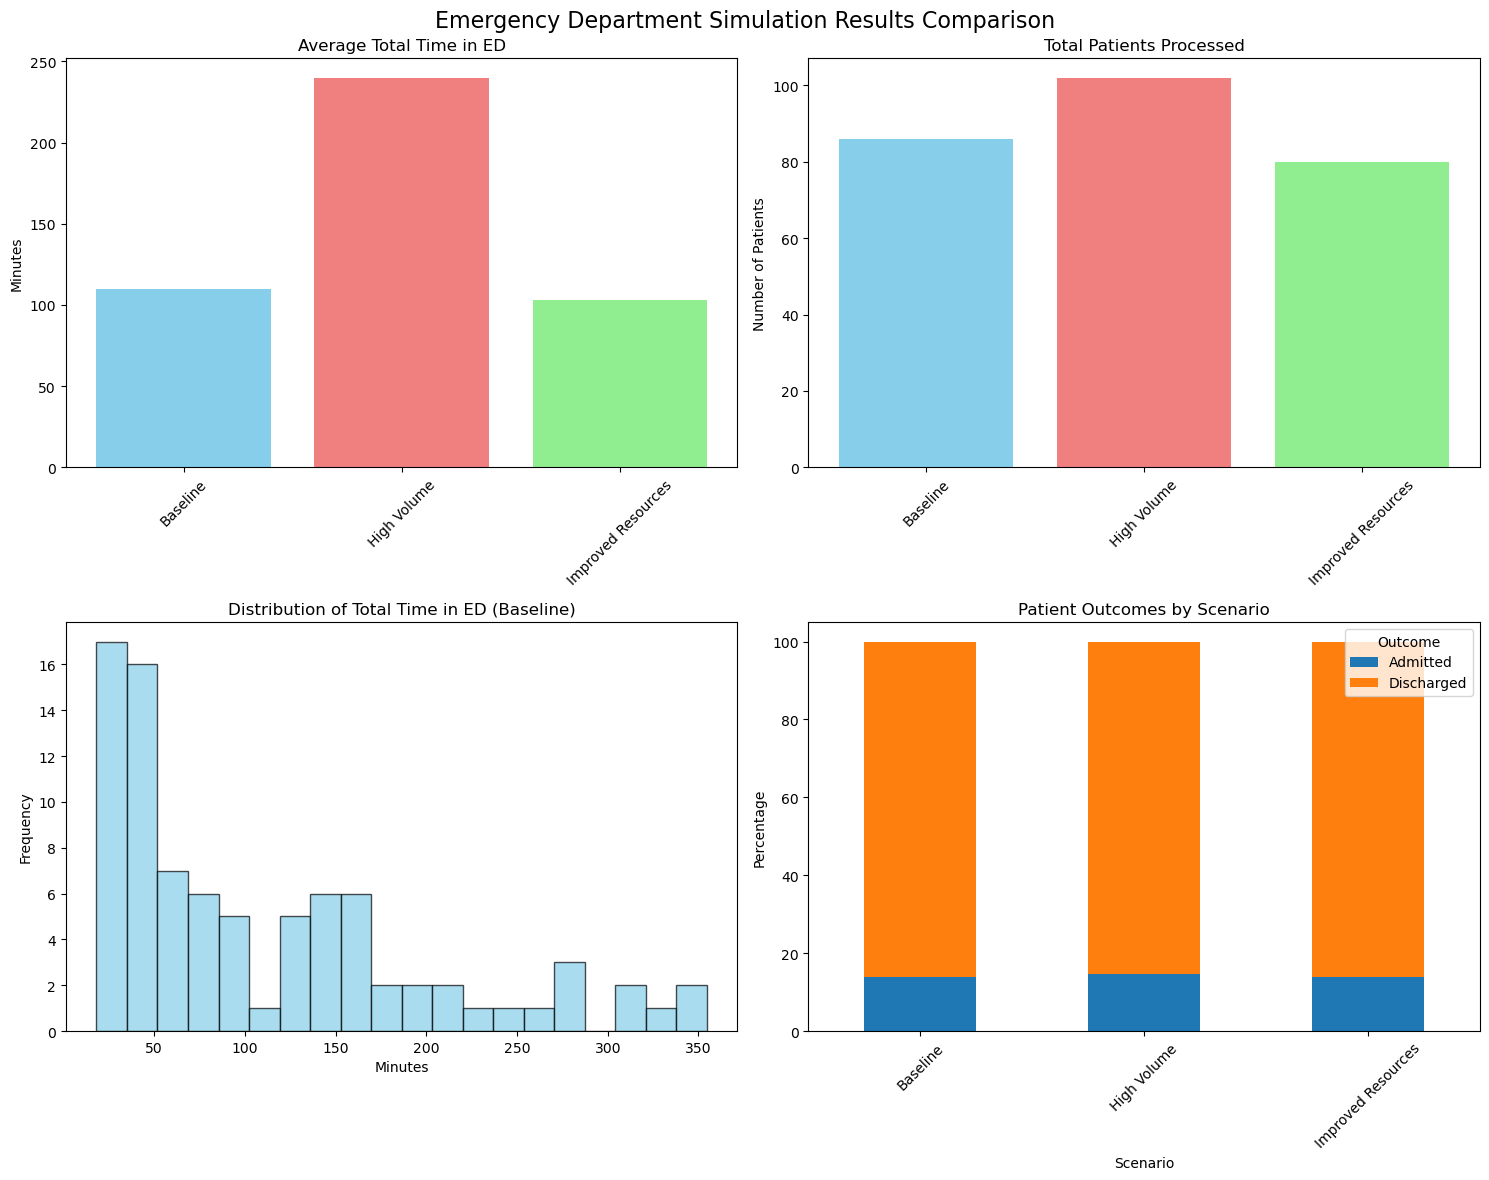


ACTIONABLE INSIGHTS AND RECOMMENDATIONS

1. IDENTIFIED BOTTLENECKS:

2. FAST TRACK PERFORMANCE:
   Fast Track average time: 39.0 minutes
   Main ED average time: 168.1 minutes
   Fast Track utilisation: 45.3% of patients

3. SCENARIO COMPARISON:
   High Volume:
   → Average time change: -119.0%
   → Patients processed: 102 vs 86 (baseline)
   Improved Resources:
   → Average time change: +5.9%
   → Patients processed: 80 vs 86 (baseline)

4. IMMEDIATE ACTIONS:
   1. Monitor queue lengths in real-time
   2. Implement triage protocols to optimise Fast Track usage
   3. Review staffing schedules during peak hours
   4. Consider process improvements for laboratory turnaround times
   5. Develop admission protocols to reduce ED boarding time

SIMULATION STUDY COMPLETE
This simulation provides insights into ED performance under different scenarios.
Use these results to make data-driven decisions about resource allocation
and process improvements.


In [9]:
# Run the simulation study
if __name__ == "__main__":
    print("Emergency Department Simulation")
    print("=====================================")
    
    # Store results for comparison
    results = {}
    
    # Scenario 1: Baseline
    print("\nRunning Baseline Scenario...")
    ed_sim_baseline, scenario_name = run_simulation(24*60, "Baseline")  # 24 hours
    patient_df_baseline, queue_df_baseline = analyse_results(ed_sim_baseline, scenario_name)
    results['Baseline'] = (patient_df_baseline, queue_df_baseline)
    
    # Scenario 2: Increased Volume (20% more patients)
    print("\nRunning High Volume Scenario...")
    # Modify the simulation for higher volume by reducing inter-arrival time
    env2 = simpy.Environment()
    ed_sim_high = EDSimulation(env2)
    
    # Override patient arrival for higher volume
    def high_volume_arrival(self):
        while True:
            # Reduced inter-arrival time (12 minutes instead of 15)
            inter_arrival_time = np.random.exponential(12)
            yield self.env.timeout(inter_arrival_time)
            
            self.patient_id += 1
            patient_type = self.determine_patient_type()
            self.env.process(self.patient_journey(self.patient_id, patient_type))
    
    # Replace the method
    ed_sim_high.patient_arrival = lambda: high_volume_arrival(ed_sim_high)
    
    env2.process(ed_sim_high.patient_arrival())
    env2.process(ed_sim_high.monitor_queues())
    env2.run(until=24*60)
    
    patient_df_high, queue_df_high = analyse_results(ed_sim_high, "High Volume")
    results['High Volume'] = (patient_df_high, queue_df_high)
    
    # Scenario 3: Improved Resources
    print("\nRunning Improved Resources Scenario...")
    env3 = simpy.Environment()
    ed_sim_improved = EDSimulation(env3)
    
    # Add more resources
    ed_sim_improved.main_ed_nurses = simpy.Resource(env3, capacity=4)  # +1 nurse
    ed_sim_improved.main_ed_doctors = simpy.Resource(env3, capacity=3)  # +1 doctor
    ed_sim_improved.main_ed_beds = simpy.Resource(env3, capacity=12)    # +2 beds
    
    env3.process(ed_sim_improved.patient_arrival())
    env3.process(ed_sim_improved.monitor_queues())
    env3.run(until=24*60)
    
    patient_df_improved, queue_df_improved = analyse_results(ed_sim_improved, "Improved Resources")
    results['Improved Resources'] = (patient_df_improved, queue_df_improved)
    
    # Create visualisations
    create_visualisations(results)
    
    # Generate recommendations
    generate_recommendations(results)
    
    print(f"\n" + "="*60)
    print("SIMULATION COMPLETE")
    print("="*60)